![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
# typing
from typing import List, Dict, Tuple, Union, Generator, Optional, Any
from pandas import DataFrame as PandasDF
from pandas import Series
from numpy import ndarray

# python
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from inspect import cleandoc

# warnings enable
import warnings
warnings.filterwarnings('ignore')

# setup
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 4)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)

In [2]:
# Importación de librerías
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


In [7]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


#### Análisis Descriptivo - Parte 1:
En primer lugar, en cuanto a la estación, parece que el número medio de préstamos de bicicletas es mayor en verano (estación 3) en comparación con las demás estaciones, seguido de primavera (estación 2). Esto sugiere una posible correlación entre el clima más cálido y una mayor demanda de bicicletas para el transporte. Además, la distribución de los préstamos en verano parece ser más amplia, con un valor máximo considerablemente mayor que en las otras estaciones.

Por otro lado, al analizar la variable de hora, hay un patrón claro de aumento en el número medio de préstamos de bicicletas durante las horas pico del día, particularmente en las horas de la mañana (entre las 7:00 y las 9:00) y las horas de la tarde (entre las 16:00 y las 18:00). Estas horas corresponden típicamente a los períodos de entrada y salida del trabajo, lo que sugiere que las bicicletas pueden ser una opción popular para la movilidad laboral. Además, se observa una disminución significativa en el número de préstamos durante la noche y las primeras horas de la mañana, alcanzando su punto mínimo alrededor de las 4:00.

En resumen, los datos revelan patrones interesantes en la demanda de préstamos de bicicletas en función de la estación y la hora del día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

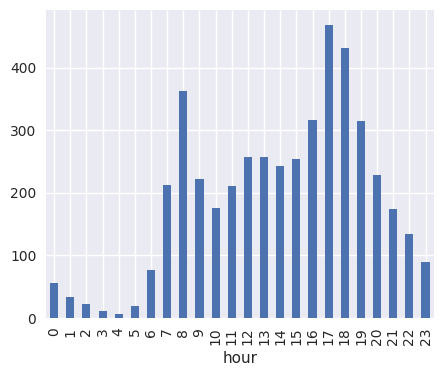

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot(kind='bar')

<Axes: xlabel='hour'>

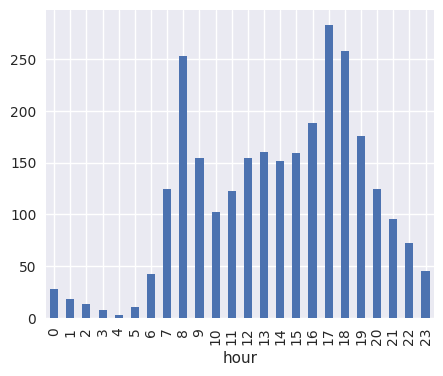

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes.season==1].groupby('hour').total.mean().plot(kind='bar')

<Axes: xlabel='hour'>

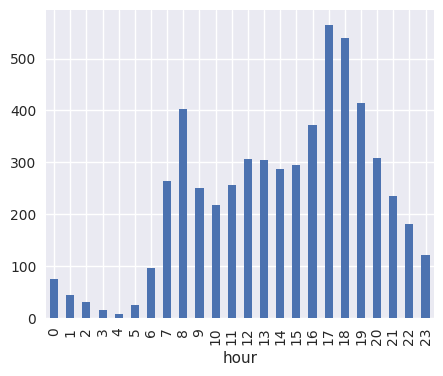

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes.season==3].groupby('hour').total.mean().plot(kind='bar')


In [11]:
# propocion de datos por season 1 y 2 frente al total de observaciones
(bikes.season==1).sum()/bikes.shape[0], (bikes.season==3).sum()/bikes.shape[0]

(0.24673893073672606, 0.25105640271908874)

#### Análisis y Hallazgos - Parte 2:
En primer lugar, durante el verano, se observa un pico pronunciado en la demanda de bicicletas en las horas de la mañana, con un aumento significativo en el número medio de bicicletas alquiladas entre las 7:00 y las 9:00, seguido de un segundo pico en las horas de la tarde, especialmente entre las 16:00 y las 18:00. Este patrón sugiere una alta utilización de bicicletas durante las horas punta, posiblemente relacionado con la movilidad laboral y recreativa en climas cálidos.

Por otro lado, en invierno, aunque se observa un aumento similar en la demanda durante las horas de la mañana y la tarde, los picos son menos pronunciados en comparación con el verano. Esto podría indicar que, aunque la bicicleta sigue siendo una opción de transporte popular durante el invierno, la demanda puede ser más estable a lo largo del día en lugar de estar concentrada en horas específicas. Además, se puede notar una disminución más marcada en el número de bicicletas alquiladas durante las horas de la madrugada y la noche en invierno en comparación con el verano, lo que sugiere una menor actividad de ciclismo en general durante los meses más fríos.

En conclusión, los gráficos de barras resaltan diferencias significativas en los patrones de alquiler de bicicletas entre el verano y el invierno en función de la hora del día. Estos hallazgos pueden ser útiles para planificar la disponibilidad de bicicletas y servicios relacionados con el alquiler.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [12]:
# Celda 3
test_size:float = 1 - 2/3
XTotal:PandasDF = bikes[['season', 'hour']].reset_index(drop=True)
yTotal:PandasDF = bikes[['total']].reset_index(drop=True)

XTotalDum = pd.concat([
    XTotal[['hour']],
    pd.get_dummies(XTotal['season'], prefix='season_' ,drop_first=True)*1],
    axis=1
)

# Regresion lineal se emplea dummy la variable season
XTrainDum, XTestDum, yTrain, yTest = train_test_split(
    XTotalDum, yTotal, test_size=test_size, random_state=0
)

# Para el arbol no se requiere usar como dummy la variable season
XTrain, XTest = \
    XTotal.iloc[XTrainDum.index,:], XTotal.iloc[XTestDum.index,:]

# validar split de arbol con total porque se toma indice del dummy
assert XTrain.shape[0] + XTest.shape[0] == XTotal.shape[0]
print(f'ok total observaciones: {XTotal.shape[0]}')

ok total observaciones: 10886


In [13]:
# Regresion lineal
lr = LinearRegression()
lr.fit(XTrainDum, yTrain)

LinearRegression()

In [14]:
XTrainDum.head()

,hour,season__2,season__3,season__4
7274,11,1,0,0
7422,15,1,0,0
2554,8,1,0,0
684,20,0,0,0
1771,17,1,0,0


In [15]:
'RMSE:', ((yTest - lr.predict(XTestDum))**2).mean().values[0]**.5

('RMSE:', 160.12768915022545)

In [16]:
lr.coef_

array([[ 10.6373601 , 100.73763983, 119.35572035,  87.01513651]])

#### Interpretación de Coeficientes, ¿Cuáles son las limitaciones de la regresión lineal? - Parte 3:
1. La interpretación de coeficientes:

- **hour:** El coeficiente para la variable "hour" sigue siendo aproximadamente 10.64. Esto significa que, manteniendo todas las demás variables constantes, por cada unidad de aumento en la hora del día, se espera un incremento de alrededor de 10.64 en el número total de bicicletas alquiladas.

- **season:** Al utilizar variables dummy para representar las estaciones del año, se está creando una representación binaria de cada estación en relación con una estación de referencia. En este caso, la estación de referencia es invierno. Por lo tanto, se han creado tres variables dummy adicionales: "season_2", "season_3" y "season_4", que representan la primavera, el verano y el otoño respectivamente. La variable "season_1" se ha omitido para evitar la multicolinealidad, ya que si conocemos los valores de "season_2", "season_3" y "season_4", automáticamente conocemos el valor de "season_1" (invierno).

    Ahora, para interpretar los coeficientes correspondientes a estas variables dummy:

- El coeficiente para "season__2" (primavera) indica cuánto cambia la respuesta promedio cuando pasamos de invierno a primavera, manteniendo todas las demás variables constantes.
- De manera similar, el coeficiente para "season__3" (verano) nos indica cuánto cambia la respuesta promedio cuando pasamos de invierno a verano, manteniendo todas las demás variables constantes.
- Por último, el coeficiente para "season__4" (otoño) indica cuánto cambia la respuesta promedio cuando pasamos de invierno a otoño, manteniendo todas las demás variables constantes.

    Para resumir lo anterior, al utilizar variables dummy, podemos interpretar los coeficientes como el cambio en la respuesta promedio en comparación con la estación de referencia (invierno), manteniendo constantes todas las otras variables en el modelo.

2. Las limitaciones principales de utilizar la regresión lineal en este caso:

- **Asunciones de linealidad:** Aunque las variables dummy permiten modelar relaciones no lineales entre las estaciones y la variable de respuesta, la regresión lineal en sí misma asume una relación lineal entre las variables predictoras y la variable de respuesta. Esto puede ser una limitación si la relación verdadera es más compleja y no puede ser adecuadamente capturada por un modelo lineal.

- **Interpretación simplificada:** La interpretación de los coeficientes de las variables dummy es relativamente sencilla, ya que representan el cambio en la respuesta promedio en relación con la categoría de referencia. Sin embargo, esta interpretación puede ser demasiado simplista si las relaciones entre las variables son más complejas. Además, al utilizar una categoría de referencia (en este caso, invierno), se asume que todas las otras estaciones se comportan de manera similar en relación con la estación de referencia, lo cual puede no ser siempre cierto.

- **Posible pérdida de información:** Al condensar la información sobre las estaciones en variables dummy, se puede perder cierta información sobre la variabilidad dentro de cada estación. Por ejemplo, si hay una gran variabilidad en la demanda de bicicletas durante el verano debido a diferencias climáticas entre regiones, esta variabilidad puede no ser capturada adecuadamente por una sola variable dummy para el verano.

- **Riesgo de multicolinealidad:** Al crear variables dummy para cada categoría, existe el riesgo de multicolinealidad si alguna de las variables dummy está altamente correlacionada con otra. En este caso, se ha evitado la multicolinealidad al eliminar una de las variables dummy (invierno) para evitar que esté perfectamente correlacionada con las otras, pero este puede no ser el caso en todos los escenarios.

En resumen, aunque las variables dummy son una forma útil de incluir variables categóricas en modelos de regresión lineal, es importante considerar sus limitaciones y asegurarse de que sean apropiadas para los datos y la pregunta de investigación específicos.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [17]:
# Celda 4
max_depth = 6
num_pct = 6

def tree_nicely(tree:Dict)->None:
    print(json.dumps(tree, indent=4, sort_keys=False))


def rmse(y)->float:
    return ((y.mean() - y)**2).mean().values[0]**.5


In [18]:
def best_split(X, y, num_pct=4):
    import math
    features = range(X.shape[1])
    # se emplea "infinito" porque se requiere minimizar el rmse
    # es decir que sea lo mas proximo a cero 
    best_split = [0, 0, math.inf]  # j, split, rmse

    # Para todas las varibles 
    for j in features:
        splits = np.linspace(X.iloc[:, j].min(), X.iloc[:, j].max(), num_pct)
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            score_rmse = rmse(y)

            if score_rmse < best_split[2]:
                best_split = [j, split, score_rmse]

    return best_split

In [19]:
def tree_grow(X, y, level=0, max_depth=1, num_pct=10):
    import math
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, rmse=math.inf)
        return tree
    
    # Calcular la mejor división
    j, split, sc_rmse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean().values[0]
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], rmse=sc_rmse)
    # Revisar el criterio de parada
    if max_depth is not None:
        if level >= max_depth:
            return tree   
   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [20]:
# Aplicación de la función tree_grow
treg = tree_grow(XTrain, yTrain, level=0, max_depth=3, num_pct=3)
tree_nicely(treg)


{
    "y_pred": 189.53121124431584,
    "level": 0,
    "split": [
        0,
        2.5
    ],
    "n_samples": 7257,
    "rmse": 181.29465097662728,
    "sl": {
        "y_pred": 163.64710743801652,
        "level": 1,
        "split": [
            0,
            1.5
        ],
        "n_samples": 3630,
        "rmse": 169.3966029047074,
        "sl": {
            "y_pred": 114.26046255506608,
            "level": 2,
            "split": [
                1,
                11.5
            ],
            "n_samples": 1816,
            "rmse": 123.39676659083247,
            "sl": {
                "y_pred": 73.51224944320712,
                "level": 3,
                "split": -1,
                "n_samples": 898,
                "rmse": 105.55938788714754
            },
            "sr": {
                "y_pred": 154.12091503267973,
                "level": 3,
                "split": -1,
                "n_samples": 918,
                "rmse": 126.52535796211598
          

In [21]:
# contar cuantas hojas tiene el arbol esto es split=-1
'Nodos Finales:', len(re.findall('-1', str(treg)))

('Nodos Finales:', 8)

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [22]:
# Celda 5
dtr = DecisionTreeRegressor(max_features="sqrt", max_depth=3)
dtr.fit(XTrain, yTrain)

DecisionTreeRegressor(max_depth=3, max_features='sqrt')

In [23]:
'RMSE:', ((yTest.total.ravel() - dtr.predict(XTest))**2).mean()**.5

('RMSE:', 132.99775951810722)

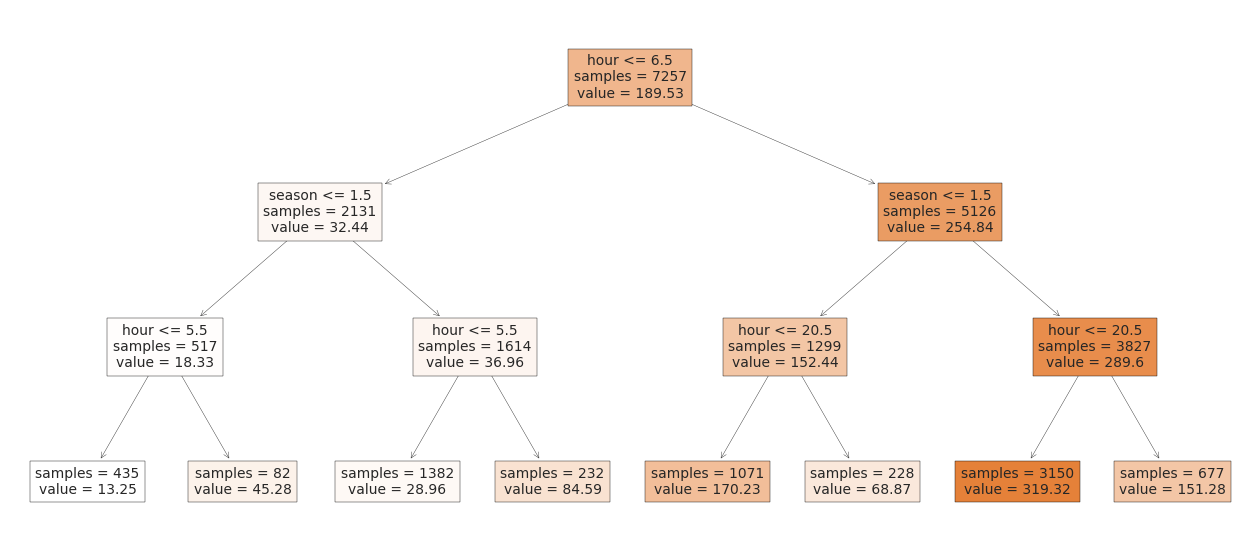

In [24]:
fig, ax = plt.subplots(figsize=(16, 7))
plot_tree(
    dtr,
    feature_names = XTrain.columns.tolist(),
    filled        = True,
    impurity      = False,
    fontsize      = 10,
    precision     = 2,
    ax            = ax
)
plt.show()

#### Desempeño Regresión Lineal y Arbol de Decisión - Punto 5
El RMSE obtenido para el árbol de decisión fue de 132.99775951810722, lo que indica que el modelo tiene un rendimiento mejorado en comparación con el modelo de regresión lineal del punto 3, que tenía un RMSE de 160.12768915022545.

Este resultado sugiere que el árbol de decisión es capaz de capturar mejor la relación no lineal entre las variables predictoras y la variable de respuesta (número de bicicletas rentadas), lo que resulta en una mejor capacidad predictiva en comparación con la regresión lineal. Sin embargo, es importante destacar que el árbol de decisión puede tener una mayor propensión al sobreajuste en comparación con la regresión lineal, por lo que es importante realizar una validación cruzada adecuada, ajustar los hiperparámetros para evitar el sobreajuste o usar técnicas como votación mayoritaria.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [25]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-report-whats-next/,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,2.0,4.702128,7.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1300.0,259.718000,0.0,843300.0,482257.142857,0.000000,6963.954292,3415.943322,4500.0,4500.0,4500.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.028582,0.028594,0.028578,0.745673,0.168573,0.625376,0.144737,0.053191,0.021277,0.714286,0.285714,0.470000,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kickstarter/,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,0.0,5.010101,8.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,919.0,250.142857,0.0,843300.0,142712.500000,0.000000,4429.750000,2610.941050,928.0,928.0,928.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.027098,0.025006,0.276713,0.025003,0.646181,0.376439,0.056574,0.030303,0.030303,0.500000,0.500000,0.342778,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-porn-clip/,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,0.0,3.972376,6.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,791.0,205.666667,4800.0,843300.0,229066.666667,2440.825000,3300.698315,2895.516309,1300.0,1300.0,1300.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.033499,0.200063,0.033411,0.033334,0.699693,0.462500,0.535795,0.049724,0.000000,1.000000,0.000000,0.516263,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-most-shared-ads-of-2013/,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,0.0,4.467350,7.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1200.0,280.800000,0.0,843300.0,335642.857143,0.000000,4415.722689,2103.971787,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.457963,0.028580,0.456140,0.028627,0.028690,0.425314,0.091016,0.030730,0.023047,0.571429,0.428571,0.436654,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-prank/,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,0.0,5.146893,4.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,935.0,268.250000,1700.0,843300.0,258100.000000,1218.111111,3588.790194,2809.374181,2400.0,8200.0,5300.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051121,0.050014,0.050167,0.050003,0.798695,0.370238,0.148214,0.039548,0.011299,0.777778,0.222222,0.346429,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [26]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [27]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [28]:
# Celda 6
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

models_pto6:Dict = dict(
    clfTree     = DecisionTreeClassifier(max_depth=5, random_state=1),
    logReg      = LogisticRegression(random_state=1),
    logRegCV    = LogisticRegressionCV(cv=5, random_state=1)
)

In [29]:
result6:Dict=dict()
for name, model in models_pto6.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    if len(result6)==0:
        result6['model']=[name]
        result6['accuracy']=[accuracy]
        result6['f1']=[f1]
    else:
        result6['model'].append(name)
        result6['accuracy'].append(accuracy)
        result6['f1'].append(f1)

In [30]:
pd.DataFrame(result6).sort_values(by='f1', ascending=False)

,model,accuracy,f1
0,clfTree,0.637333,0.661692
2,logRegCV,0.619333,0.610770
1,logReg,0.611333,0.608462


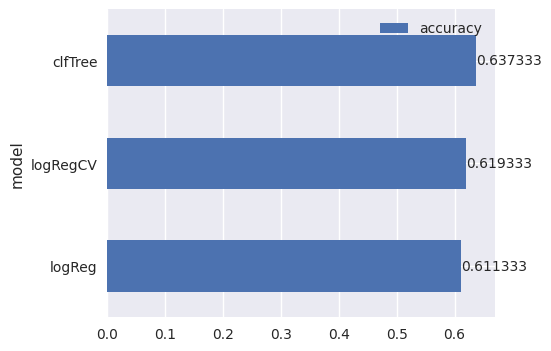

In [31]:
ax = (
    pd.DataFrame(result6)
        .set_index('model')
        .sort_values(by='accuracy')
        .plot(kind='barh', y='accuracy')
)
ax.bar_label(ax.containers[0])
plt.show()

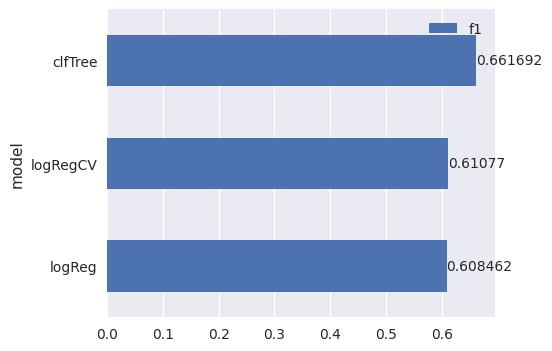

In [32]:
ax = (
    pd.DataFrame(result6)
        .set_index('model')
        .sort_values(by='f1')
        .plot(kind='barh', y='f1')
)
ax.bar_label(ax.containers[0])
plt.show()

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados.

Nota:

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

- para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
- para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
- para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (10055%+10055%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [191]:
# Celda 7
from sklearn.ensemble import BaggingClassifier, VotingClassifier
params:Dict=dict(
    n_estimators=100,
    bootstrap=True,
    random_state=1,
    n_jobs=-1, 
    oob_score=True
)

# How To Solve Logistic Regression Not Converging in Scikit-Learn
# https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/
models_pto7:Dict = dict(
    clfTreeMDBagg   = BaggingClassifier(DecisionTreeClassifier(max_depth=3), **params),
    clfTreeMSBagg   = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=2), **params),
    logRegBagg      = BaggingClassifier(LogisticRegression(penalty='l1', C=0.01, solver='liblinear'), **params)
)

In [192]:
result7:Dict=dict()
for name, model in models_pto7.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    if len(result7)==0:
        result7['model']=[name]
        result7['accuracy']=[accuracy]
        result7['f1']=[f1]
    else:
        result7['model'].append(name)
        result7['accuracy'].append(accuracy)
        result7['f1'].append(f1)

In [193]:
pd.DataFrame(result7).sort_values(by='f1', ascending=False)

,model,accuracy,f1
1,clfTreeMSBagg,0.644667,0.647720
0,clfTreeMDBagg,0.651333,0.645424
2,logRegBagg,0.631333,0.615170


In [194]:
avgVotingMajority = VotingClassifier(
    estimators=[
        (name, model)
        for name, model in models_pto7.items()
    ],
    voting='hard',
    n_jobs=1
)

In [195]:
avgVotingMajority.fit(X_train, y_train)

VotingClassifier(estimators=[('clfTreeMDBagg',
                              BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                n_estimators=100, n_jobs=-1,
                                                oob_score=True,
                                                random_state=1)),
                             ('clfTreeMSBagg',
                              BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=2),
                                                n_estimators=100, n_jobs=-1,
                                                oob_score=True,
                                                random_state=1)),
                             ('logRegBagg',
                              BaggingClassifier(estimator=LogisticRegression(C=0.01,
                                                                             penalty='l1',
                                                                             solver='liblinear'),
                                                n_estimators=100, n_jobs=-1,
                                                oob_score=True,
                                                random_state=1))],
                 n_jobs=1)

In [196]:
y_pred = avgVotingMajority.predict(X_test)
result7['model'].append('VotingMajority')
result7['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
result7['f1'].append(metrics.f1_score(y_test, y_pred))

In [197]:
pd.DataFrame(result7)[pd.DataFrame(result7).model=='VotingMajority']\
    .sort_values(by='f1', ascending=False)

,model,accuracy,f1
3,VotingMajority,0.65,0.645988


#### Comentarios y conclusiones - Punto 7
Al evaluar los modelos de bagging (voto mayoritario) individualmente, se puede observar que cada modelo tiene un rendimiento similar en términos de Accuracy y F1-Score, con valores que oscilan alrededor del 64% al 65%. Esto indica que los modelos (voto mayoritario de 100, 100 y 100) tienen una capacidad predictiva comparable en el conjunto de datos.

Al evaluar el ensamble de los 3 modelos con un Voting Mayoritario (300), observamos que los resultados son también muy similares a los de los modelos individuales, con un Accuracy de 65% y un F1-Score de 64.6%. En general, el ensamble no muestra una mejora significativa sobre los modelos individuales en términos de predicción de precisión y rendimiento F1.

En el enfoque de bagging (voto mayoritario de 100, 100 y 100) se están empleando múltiples instancias del mismo tipo de modelo (árboles de decisión y regresión logística), lo que resulta en modelos homogéneos. Por otro lado, el Voting Mayoritario (300), al combinar diferentes tipos de modelos (árboles de decisión y regresión logística), representa un enfoque heterogéneo.

La heterogeneidad entre los modelos en el Voting Mayoritario puede ofrecer una mayor diversidad en las predicciones, lo que podría mejorar la capacidad del ensamble para generalizar y proporcionar mejores resultados en comparación con un conjunto de modelos homogéneos. Esta diversidad puede ayudar a capturar diferentes aspectos y patrones de los datos que pueden ser pasados por alto por un solo tipo de modelo.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [198]:
# Celda 8
# Cálculo del error the out-of-bag con el R-cuadrado (no con el MSE) [de 0 a 1]
oobs: List = np.array([model.oob_score_ for model in models_pto7.values()])
oobs

array([0.63266667, 0.622     , 0.62977778])

In [200]:
VotingWeight = VotingClassifier(
    estimators=[
        (name, model)
        for name, model in models_pto7.items()
    ],
    # soft: predicts the class label based on the argmax 
    # of the sums of the predicted probabilities, which is 
    # recommended for an ensemble of well-calibrated classifiers.
    voting='soft',

    # si emplea alpha = (1-oobs) / (1-oobs).sum() 
    # el modelo arroja una menor performance esto porque el oobs
    # es el r2 muy distinto al mse y el alpha está pensado
    # para cada una de las predicciones aquí es diferente porque
    # los 3 modelos ya fueron ensamblados previamente
    weights=oobs, 
    n_jobs=1
)

In [201]:
VotingWeight.fit(X_train, y_train)

VotingClassifier(estimators=[('clfTreeMDBagg',
                              BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                n_estimators=100, n_jobs=-1,
                                                oob_score=True,
                                                random_state=1)),
                             ('clfTreeMSBagg',
                              BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=2),
                                                n_estimators=100, n_jobs=-1,
                                                oob_score=True,
                                                random_state=1)),
                             ('logRegBagg',
                              BaggingClassifier(estimator=LogisticRegression(C=0.01,
                                                                             penalty='l1',
                                                                             solver='liblinear'),
                                                n_estimators=100, n_jobs=-1,
                                                oob_score=True,
                                                random_state=1))],
                 n_jobs=1, voting='soft',
                 weights=array([0.63266667, 0.622     , 0.62977778]))

In [202]:
y_pred = VotingWeight.predict(X_test)
result7['model'].append('VotingWeight')
result7['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
result7['f1'].append(metrics.f1_score(y_test, y_pred))

In [203]:
pd.DataFrame(result7)[pd.DataFrame(result7).model=='VotingWeight']\
    .sort_values(by='f1', ascending=False)

,model,accuracy,f1
4,VotingWeight,0.651333,0.64686


#### Comentarios y conclusiones - Punto 8
En este caso la votación ponderada (300) muestra unas métricas ligeramente menjores que la votación mayoritaria (300) al usarse los errores Out-of-Bag (oobs) como pesos debido a lo siguiente:

- **Consideración de la confianza del modelo:** Los errores Out-of-Bag (oobs) proporcionan una medida de la calidad y confianza de cada modelo individual en el ensamble. Al utilizar estos errores como pesos en la Votación ponderada, se está teniendo en cuenta la capacidad predictiva relativa de cada modelo. Los modelos con errores Out-of-Bag más bajos (indicando una mejor capacidad predictiva en los datos no vistos durante el entrenamiento) recibirán mayores pesos en la votación, lo que significa que sus predicciones tendrán un impacto más significativo en la decisión final del ensamble.

- **Optimización de la combinación de modelos:** Al asignar pesos basados en los errores Out-of-Bag, la Votación ponderada optimiza la combinación de modelos de acuerdo con su rendimiento relativo en datos no vistos. Esto puede conducir a una mejor generalización del modelo y a una mejora en la precisión de las predicciones en comparación con la Votación Mayoritaria, donde todos los modelos tienen el mismo peso independientemente de su rendimiento.

- **Reducción del sesgo en la votación:** Al ponderar las predicciones de los modelos en función de su rendimiento, la Votación ponderada puede reducir el sesgo hacia modelos menos confiables y más propensos al sobreajuste. Esto puede resultar en una votación más equilibrada y una toma de decisiones más robusta por parte del ensamble.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

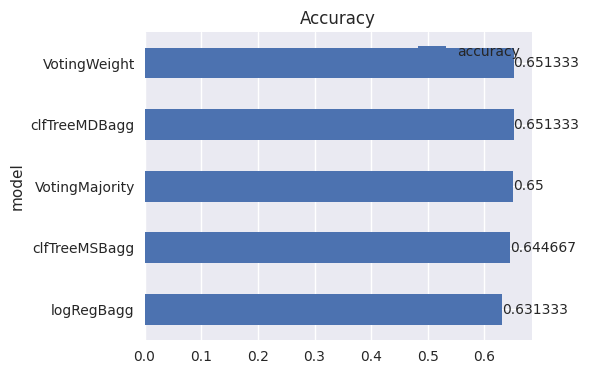

In [204]:
# Celda 9
ax = (
    pd.DataFrame(result7)
        .set_index('model')
        .sort_values(by='accuracy')
        .plot(kind='barh', y='accuracy', title='Accuracy')
)
ax.bar_label(ax.containers[0])
plt.show()

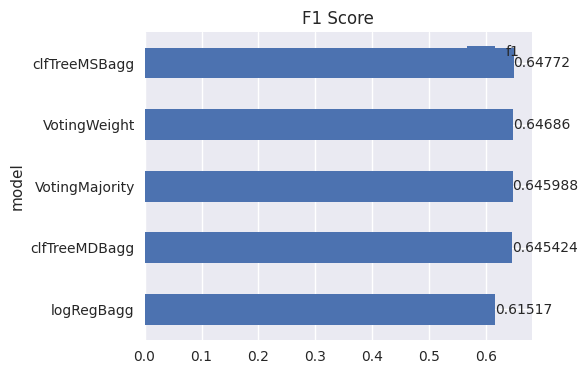

In [205]:
ax = (
    pd.DataFrame(result7)
        .set_index('model')
        .sort_values(by='f1')
        .plot(kind='barh', y='f1', title='F1 Score')
)
ax.bar_label(ax.containers[0])
plt.show()

In [206]:
pd.DataFrame(result7).sort_values(by='f1', ascending=False)

,model,accuracy,f1
1,clfTreeMSBagg,0.644667,0.647720
4,VotingWeight,0.651333,0.646860
3,VotingMajority,0.650000,0.645988
0,clfTreeMDBagg,0.651333,0.645424
2,logRegBagg,0.631333,0.615170


#### Resultados, Ventajas y Desventajas

- En términos de precisión (accuracy) y puntaje F1, tanto el ensamble de Votación Mayoritaria como el ensamble de Votación Ponderada muestran resultados muy similares a los modelos individuales, con diferencias mínimas.
- Una posible ventaja de la Votación Ponderada sobre la Votación Mayoritaria es la consideración de la confianza y calidad relativa de cada modelo, lo que puede conducir a una mejor generalización y precisión en las predicciones.
- Sin embargo, la implementación de la Votación Ponderada requiere calcular los errores Out-of-Bag de cada modelo (Bagging 100, 100 y 100), lo que puede ser computacionalmente costoso en conjuntos de datos grandes.
- Por otro lado, la Votación Mayoritaria es más simple de implementar y puede ser más eficiente computacionalmente, aunque puede no aprovechar completamente la información sobre la calidad de cada modelo en el ensamble.

En conclusión, ambas metodologías de ensamble (Votación Mayoritaria y Votación Ponderada) ofrecen resultados comparables y pueden ser apropiadas dependiendo de las necesidades específicas del problema y los recursos computacionales disponibles. La elección entre ellas puede depender de consideraciones prácticas, como el tiempo de cómputo y la interpretabilidad del modelo, así como de los objetivos de rendimiento específicos del problema en cuestión.